# RNN в обработке текстов.

In [24]:
import warnings
import string
import random
import torch
import sklearn
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import List, Tuple
from razdel import tokenize, sentenize
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator
warnings.filterwarnings("ignore")

### Применение RNN  в расшифровке текстов

Шифр цезаря работает следующим образом: каждая буква исходного алфавита сдвигается на K символов вправо:
Пусть нам дано сообщение: message="RNN IS NOT AI", тогда наше шифрование даст нам результат: f(message, K) = TPPBKUBPQVBCK.
Для удобства возьмём символы только верхнего регистра, все буквы не английского алфавита будут отмечены как прочерк "-".

In [2]:
class Caesar:
    BIG_ENG = ' ' + string.ascii_uppercase

    def __init__(self, message: str, step: int):
        self.__message = message
        self.__step = step % 26

    def __str__(self):
        return self.__message

    @classmethod
    def __create_string(cls, string: str, step: int) -> str:
        result = []
        for symbol in string:
            if symbol in cls.BIG_ENG:
                result.append(cls.BIG_ENG[(cls.BIG_ENG.index(symbol) + step) % len(cls.BIG_ENG)])
            else:
                result.append('-')
        result = ''.join(result)
        return result

    def encrypt(self) -> str:
        return Caesar.__create_string(self.__message.upper(), self.__step)

In [3]:
cipher = Caesar(message := 'RNN IS NOT AI', 2)
print('сообщение:', message, '| зашифрованное сообщение:', cipher.encrypt())

сообщение: RNN IS NOT AI | зашифрованное сообщение: TPPBKUBPQVBCK


Теперь нам необходимо нагенерировать датасет для решения задачи обучения с учителем. Нашим датасетом может быть случайно зашифрованные фразы, и тогда его структура будет следующей: message --- encrypted message.
Это пример параллельного корпуса из НЛП.
Но нам необходимо представить каждую букву в виде ее номера в словаре, чтобы далее воспользоваться Embedding слоем.

In [3]:
class EncryptedDataset:
    
    Dataset = List[Tuple[torch.Tensor, torch.Tensor]]
    
    def __init__(self, dataset_len: int, message_len: int, key: int):
        self.__dataset_len = dataset_len # длина датасета
        self.__message_len = message_len # длина слов
        self.key = key # ключ для шифрования сообщения
        self.dataset = self.__create_dataset(dataset_len, message_len) # сгенерированный датасет
    
    def __len__(self):
        return self.__dataset_len
    
    def __getitem__(self, index):
        return self.dataset[index]
    
    def message_len(self):
        return self.__message_len
    
    def __create_dataset(self, dataset_len: int, message_len: int) -> Dataset:
        dataset = []
        vocabulary = Caesar.BIG_ENG
        for _ in range(dataset_len):
            # генерируется сообщение, состоящее из случайных символов
            message = [random.choice(Caesar.BIG_ENG) for _ in range(message_len)]
            # сообщение шифруется по Цезарю
            encrypted = Caesar(message := ''.join(message), self.key).encrypt()
            # сохраняются индексы символов сообщения для дальнейшего обучения
            src = [vocabulary.index(symbol) for symbol in message]
            # сохраняются индексы символов шифра для дальнейшего обучения
            tgt = [vocabulary.index(symbol) for symbol in encrypted]
            dataset.append((torch.tensor(tgt), torch.tensor(src)))
        return dataset

**Pytorch RNN:**
$$h_t = \text{tanh}(w_{ih} x_t + b_{ih} + w_{hh} h_{(t-1)} + b_{hh})$$

**where : $h_t$ is the hidden state at time $t$, $x_t$ is
    the input at time $t$, and $h_{(t-1)}$ is the hidden state of the
    previous layer at time $t-1$ or the initial hidden state at time $0$.**
    
Args:

        input_size: The number of expected features in the input $x$
        hidden_size: The number of features in the hidden state $h$
        num_layers: Number of recurrent layers. E.g., setting

In [4]:
class Decipher(torch.nn.Module):
    def __init__(self, vocabulary_len: int, # размер словаря
                 embedding_dim: int, # размер векторного представления слов
                 hidden_dim: int, # размер скрытого слоя
                 output_dim: int=None): # кол-во классов для предсказания 
        super(Decipher, self).__init__()
        # инициализация слоя эмбендинга для работы с текстовыми данными
        self.embedding = torch.nn.Embedding(vocabulary_len, embedding_dim)
        # инициализация начального скрытого состояния RNN
        self.initial_hidden = torch.zeros(rnn_layers := 2, 1, hidden_dim)
        # рекурентная двухслойная нейронная сеть
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, num_layers=rnn_layers)
        # инициализация линейного полносвязйного слоя
        self.fc = torch.nn.Linear(hidden_dim, vocabulary_len)

    def forward(self, cipher):
        # получение векторного представления каждого символа входящего сообщения
        embd_x = self.embedding(cipher).unsqueeze(1) # расширение размерности для входа в rnn
        # применение rnn к веторам и начальному скрытому состоянию
        # на выходе получается выходные значения rnn и конечное скрытое состояние 
        out_rnn, hidden = self.rnn(embd_x, self.initial_hidden)
        # применение полносвязного слоя к выходу rnn для получения вероятности каждого символа
        output = self.fc(out_rnn).transpose(1, 2)
        return output

In [5]:
dataset = EncryptedDataset(256, 18, 10)
# определим параметры нашей модели
embedding_dim = 5
hidden_dim = 10
vocab_size = len(Caesar.BIG_ENG)
learning_rate = 1e-3
# функция ошибки
criterion = torch.nn.CrossEntropyLoss()
# инициализация модели
model = Decipher(vocab_size, embedding_dim, hidden_dim)
# инициализация оптимизатора Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# кол-во эпох обучения модели
for epoch in range(num_epochs := 10):
    for encrypted, original in dataset.dataset:
        scores = model(encrypted) # прогон зашифрованных сообщений через слои модели
        loss = criterion(scores, original.unsqueeze(1)) # вычисление функции ошибки
        optimizer.zero_grad() # очистка вычисленных градиентов
        loss.backward() # вычисление градиента функции потерь по всем параметрам модели
        optimizer.step() # оптимизация весов модели
    print('Epoch: {} | Loss: {:6.4f} | '.format(epoch, loss.item()), end='')
    with torch.no_grad():
        matches, total = 0, 0
        for encrypted, original in dataset.dataset:
            # вычисление softmax на предскказанных значениях модели
            predictions = torch.nn.functional.softmax(model(encrypted), 1)
            # Choose the character with the maximum probability (greedy decoding)
            _, batch_out = predictions.max(dim=1)
            # Remove batch
            batch_out = batch_out.squeeze(1)
            # Calculate accuracy
            matches += torch.eq(batch_out, original).sum().item()
            total += torch.numel(batch_out)
        accuracy = matches / total * 100
        print('Accuracy: {:4.2f}%'.format(accuracy))

Epoch: 0 | Loss: 2.6782 | Accuracy: 26.52%
Epoch: 1 | Loss: 1.7317 | Accuracy: 76.61%
Epoch: 2 | Loss: 1.1274 | Accuracy: 93.14%
Epoch: 3 | Loss: 0.7531 | Accuracy: 96.55%
Epoch: 4 | Loss: 0.5073 | Accuracy: 99.98%
Epoch: 5 | Loss: 0.3478 | Accuracy: 100.00%
Epoch: 6 | Loss: 0.2506 | Accuracy: 100.00%
Epoch: 7 | Loss: 0.1887 | Accuracy: 100.00%
Epoch: 8 | Loss: 0.1468 | Accuracy: 100.00%
Epoch: 9 | Loss: 0.1171 | Accuracy: 100.00%


## Применение RNN в классификации текстов

Сравнение результатов с классическими методами машинного обучения.

In [2]:
data = pd.concat([pd.read_csv('banki_1.csv'), pd.read_csv('banki_2.csv')], ignore_index=True)
data['datePublished'] = data['datePublished'].astype('datetime64[ns]')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24125 entries, 0 to 24124
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   author         23986 non-null  object        
 1   datePublished  24125 non-null  datetime64[ns]
 2   bank           24125 non-null  object        
 3   telephone      24125 non-null  object        
 4   address        24125 non-null  object        
 5   postalCode     24125 non-null  int64         
 6   name           24125 non-null  object        
 7   review         24125 non-null  object        
 8   rating         24125 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 1.7+ MB


Оставим только весомые признаки, остальные удалим:

In [3]:
# удалим дубликаты
data.drop_duplicates(inplace=True)
# удалим уникальные и сильно коррелирующие колонки:
data.drop(columns=['author', 'datePublished', 'postalCode', 'address', 'telephone'], axis=1, inplace=True)
data.head()

,bank,name,review,rating
0,Альфа-Банк,Очень быстрое обслуживание,Добрый день! Хочу похвалить работников офиса в...,5
1,Сбербанк,Не увеличен лимит по кредитной карте,"20.07 пришло смс с номера 900 о том, что до 27...",1
2,Сбербанк,Кредитный лимит по карте так и не увеличили,20.07.2023 числа пришло смс с номера 900 от Сб...,3
3,Альфа-Банк,Отличный банк,"Прекрасный банк, прекрасное обслуживание. Поль...",5
4,Сбербанк,Замена паспорта и вместе с ней потеря кредитно...,Приветствую. Столкнулся с пренеприятнейшей ист...,1


Проверим баланс классов:

In [11]:
data['rating'].value_counts()

5    16211
1     5250
4      996
2      710
3      315
Name: rating, dtype: int64

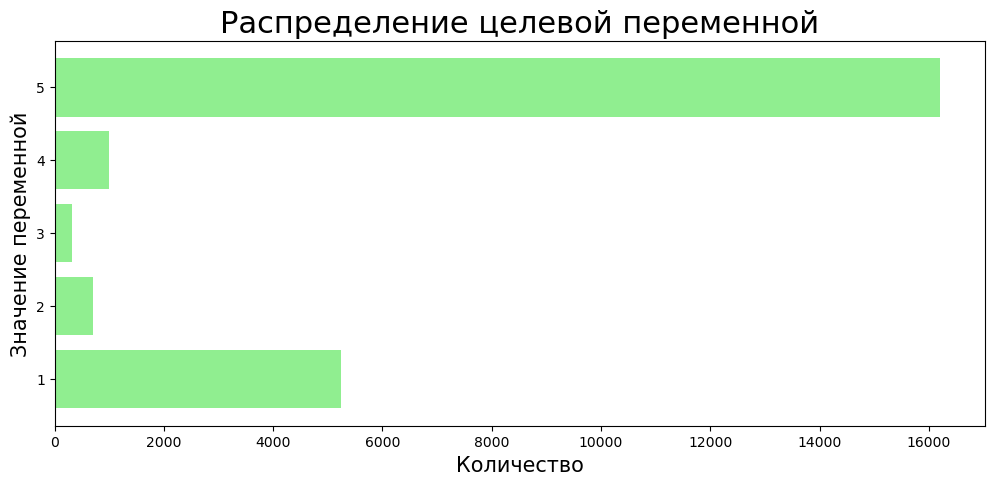

In [12]:
rating = data['rating'].value_counts()
fig = plt.figure(figsize=(12,5))
ax=fig.subplots()
plt.barh(rating.index, rating.values, align='center', color='lightgreen')
plt.title("Распределение целевой переменной", fontsize=22)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Значение переменной', fontsize=15)
plt.show()

Сбалансируем классы путём повышения миноритарных признаков и понижения мажоритарных до одинакового значения = 1500

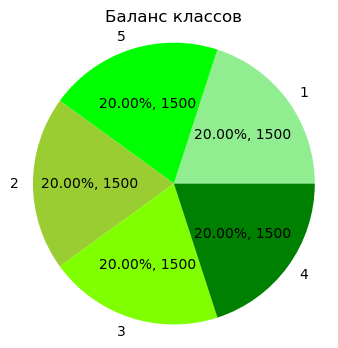

In [4]:
values = 1500
one = data[data['rating'] == 1]
two = data[data['rating'] == 2]
three = data[data['rating'] == 3]
four = data[data['rating'] == 4]
five = data[data['rating'] == 5]
data_balanced = pd.concat([one.sample(n=values, random_state=25),
                           five.sample(n=values, random_state=25),
                           two.sample(n=values, random_state=25, replace=True),
                           three.sample(n=values, random_state=25, replace=True),
                           four.sample(n=values, random_state=25, replace=True)])
plt.figure(figsize=(4, 4))
value_counts = data_balanced['rating'].value_counts()
plt.pie(value_counts, labels=value_counts.index,
        autopct=lambda p:f'{p:.2f}%, {p * sum(value_counts) / 100 :.0f}',
        colors=['lightgreen', 'lime', 'yellowgreen', 'chartreuse', 'green'])
plt.title('Баланс классов')
plt.axis('equal')
plt.show()

Подготовим функции для обработки текста: функция для очистки текста от незначащих символов, ненужных слов; класс-наследник Dataset для обучения загрузки данных в DataLoader для обучений rnn; функция векторизатор для преобразования текста в числа через встроенные векторизаторы или через преобразования в тензоры из словаря.

In [37]:
def text_clearing(dataset: pd.DataFrame) -> pd.DataFrame:
    """Функция очистки датасета от лишних столбцов и значений в строках и преобразования текстовых данных"""
    stop_words = set(stopwords.words('russian')) # незначащие русские слова
    lemma = MorphAnalyzer() # лематизатор русского текста
    def tokenizer(text: str) -> list[str]:
        """Функция токенизирования, лемматизации и удаления стоп-слов"""
        nonlocal lemma, stop_words
        text = list(map(lambda word: word.text, tokenize(text))) # токенизация слов
        text = [lemma.normal_forms(word)[0] for word in text # лемматизация слов
           if word.isalpha() # проверка, что слово состоит из букв
           and len(word) < 20 # проверка, что длина слова от 3 до 20
           and word not in stop_words] # удаление стоп слов
        text = ' '.join(text) # объединения в единый текст для дальнейшего обучения 
        return text
    # определение регулярных выражений
    str_1 = '. '
    regex_1 = r'(?<=\().+?(?=\))'
    regex_2 = r'[\d\(\)a-zA-Z]'
    # Объединение названий отзывов и их содержимых
    dataset['review'] = dataset['bank'] + str_1 + dataset['name'] + str_1 + dataset['review']
    dataset.drop(columns=['name', 'bank'], inplace=True)
    # Удаление содержимого в скобках и приведение к нижнему регист
    dataset['review'] = dataset['review'].str.replace(regex_1, '', regex=True)
    # Удаление чисел, скобок и латинский алфавит
    dataset['review'] = dataset['review'].str.replace(regex_2, '', regex=True)
    # токенизация и лемматизация слов
    dataset['review'] = dataset['review'].apply(tokenizer)
    return dataset

class MyDataset(Dataset):
    """Класс-наследний Dataset pytorch для обучения многослойной нейронной сети"""
    def __init__(self, X_train, y_train):
        df = pd.DataFrame()
        df['X'] = [vector for vector in X_train]
        self.X = df.X
        self.y = y_train.reset_index(drop=True)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]
            
def vectorizer(dataset: pd.DataFrame, vectorizer, batch_size=None):
    """Функция векторизирования строчных данных и разбиения на тестовые и тренировочные датасеты"""
    X, y = dataset['review'], dataset['rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=100)
    if batch_size is None:
        return vectorizer.fit_transform(X_train), vectorizer.transform(X_test), y_train, y_test
    
    def build_vocabulary(datasets):
        """Генератор словаря torch"""
        for dataset in datasets:
            for text in dataset:
                yield text.split()
    
    vocab = build_vocab_from_iterator(build_vocabulary([X_train, X_test]), min_freq=1, specials=["<UNK>"])
    vocab.set_default_index(vocab["<UNK>"])
    
    def to_tensor(batch):
        """Функция для преобразования признаков и классов в Tensor"""
        nonlocal vocab
        X, Y = list(zip(*batch))
        X = [vocab(text.split()) for text in X]
        X = [tokens + ([0] * (50 - len(tokens))) if len(tokens) < 50 else tokens[:50] for tokens in X]
        return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1
    
    train_loader = DataLoader(MyDataset(X_train, y_train), batch_size=batch_size, collate_fn=to_tensor)
    test_loader = DataLoader(MyDataset(X_test, y_test), batch_size=batch_size, collate_fn=to_tensor)
    return vocab, train_loader, test_loader

Очистка сбалансированного датасета:

In [6]:
%%time
data_balanced = text_clearing(data_balanced)

Wall time: 3min 36s


Очистка изначального датасета:

In [7]:
%%time
data = text_clearing(data)

Wall time: 9min 11s


Создадим датасеты для обучения на классических моделях:

In [13]:
%%time
datas = {'balanced(tfidf)': vectorizer(data_balanced, TfidfVectorizer()),
         'unbalanced(tfidf)': vectorizer(data, TfidfVectorizer()),
         'balanced(countv)': vectorizer(data_balanced, CountVectorizer()),
         'unbalanced(countv)': vectorizer(data, CountVectorizer()),
         'balanced(hash)': vectorizer(data_balanced, HashingVectorizer()),
         'unbalanced(hash)': vectorizer(data, HashingVectorizer())}

Wall time: 7.8 s


Обучим и сравним классические модели машинного обучения

In [76]:
def train_model(model):
    """Функция обучения всех датасетов на одной модели для сравнения"""
    global datas
    def train(model, X_train, X_test, y_train, y_test):
        """Функция обучения модели"""
        start = time.time()
        model = model().fit(X_train, y_train)
        train_time = time.strftime("%H:%M:%S", time.gmtime(round(time.time() - start, 2)))
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        score_train = round(accuracy_score(y_train, y_train_pred), 4)
        score_test = round(accuracy_score(y_test, y_test_pred), 4)
        return train_time, score_train, score_test
    
    vector_balances, train_times, train_scores, test_scores = [], [], [], []
    for train_test in tqdm(list(datas.items())):
        result_training = train(model, train_test[1][0], train_test[1][1],
                                train_test[1][2], train_test[1][3])
        vector_balances.append(train_test[0])
        train_times.append(result_training[0])
        train_scores.append(result_training[1])
        test_scores.append(result_training[2])
        
    """График сравнения скорости обучения и тестирования и разных метрик на разных датасетах"""
    plt.figure(figsize=(8, 6))
    plt.bar(vector_balances, train_scores, width=.5, label='На тренировочных данных', alpha=.5, color='#ADFF2F')
    plt.bar(vector_balances, test_scores, width=.5, label='На тестовых данных', alpha=.5, color='#32CD32')
    for i in range(len(vector_balances)):
        plt.text(i, 1, train_scores[i], ha = 'center')
        time_n_acc = f'{train_times[i]}\n{test_scores[i]}'
        plt.text(i, test_scores[i], time_n_acc, ha = 'center', bbox = dict(facecolor = '#32CD32', alpha =.8))
    plt.yticks(np.arange(0, 1.2, 0.1))
    plt.title('Результат модели при разной балансировки и разной векторизации', fontweight ='bold')
    plt.xlabel('Датасеты', fontweight ='bold')
    plt.xticks(rotation=15)
    plt.ylabel('Метрика точности', fontweight ='bold')
    plt.legend(loc='lower center')
    plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

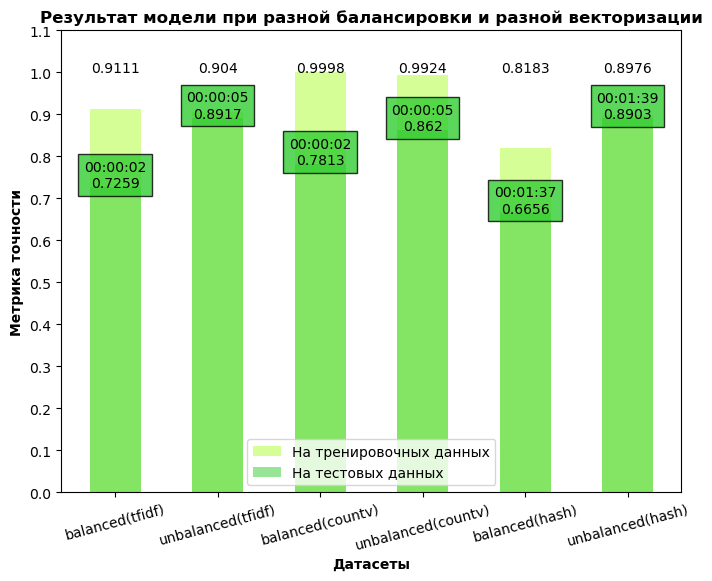

In [77]:
train_model(LogisticRegression)

  0%|          | 0/6 [00:00<?, ?it/s]

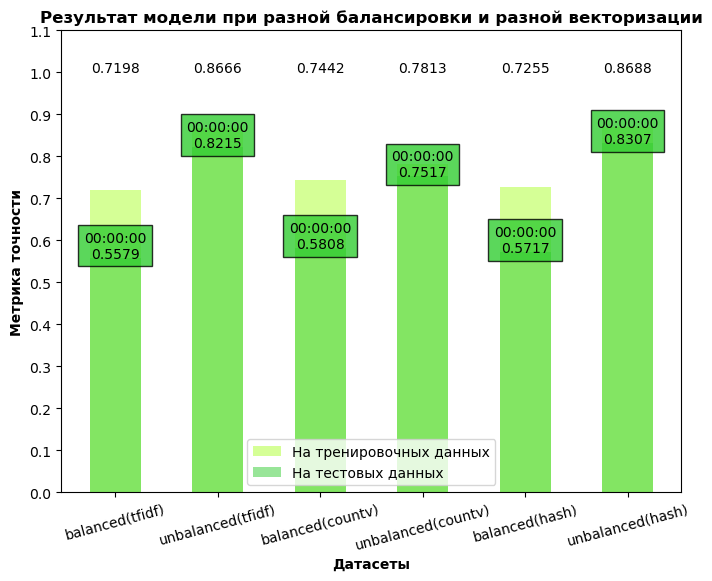

In [78]:
train_model(KNeighborsClassifier)

  0%|          | 0/6 [00:00<?, ?it/s]

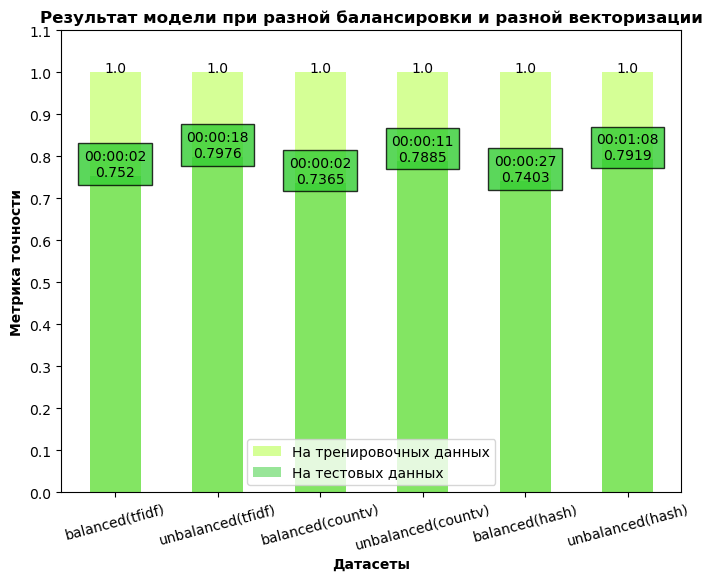

In [79]:
train_model(DecisionTreeClassifier)

  0%|          | 0/6 [00:00<?, ?it/s]

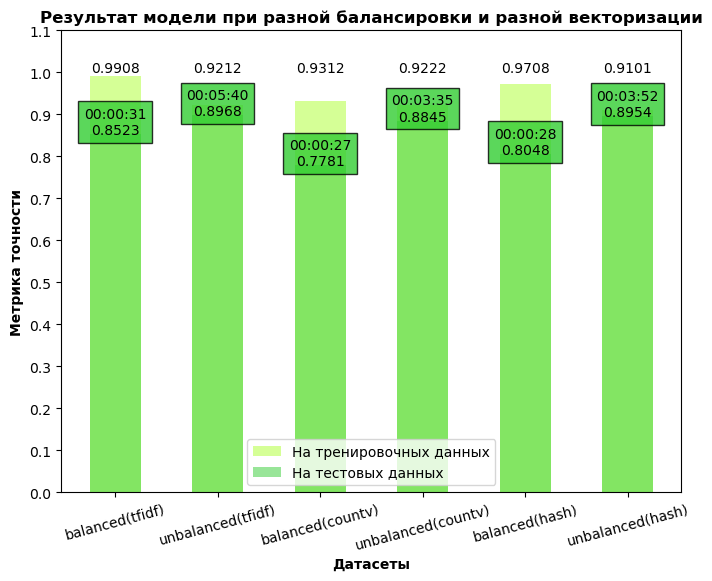

In [81]:
train_model(SVC)

Вывод: наилучший результат даёт модель SVC, но также по скорости обучения она значительно уступает другим моделям; результат на тренировочных данных показывает около 90%, что, при небольшом объёме датасета, достаточно высокое значение. 

Подготовим данные для обучения RNN:

In [38]:
%%time
datas = {'balanced(tfidf)': vectorizer(data_balanced, TfidfVectorizer(), batch_size=256),
         'balanced(countv)': vectorizer(data_balanced, CountVectorizer(), batch_size=256),
         'unbalanced(tfidf)': vectorizer(data, TfidfVectorizer(), batch_size=256),
         'unbalanced(countv)': vectorizer(data, CountVectorizer(), batch_size=256)}

Wall time: 2.72 s


Подготовим модель рекурентной нейронной сети к обучению. Она состоит из слоя эмбеддинга для обработки текста, слоя самой сети с функцией активации relu для избежания линейности и линейного полносвязного слоя, который и будет давать на выходе один из 5 возможных классов (оценок отзывов):

In [99]:
class MyRNN(torch.nn.Module):
    def __init__(self, vocab_size: int, # размер словаря
                 embedding_dim: int, # размер векторного представления слов
                 hidden_dim: int, # размер скрытого слоя
                 num_classes: int, # кол-во классов для предсказания 
                 rnn_layers: int): # кол-во слоёв rnn
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn_layers = rnn_layers
        # инициализация слоя эмбендинга для работы с текстовыми данными
        self.emb = torch.nn.Embedding(vocab_size, embedding_dim)
        # рекурентная нейронная сеть
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, num_layers=rnn_layers, batch_first=True,
                                nonlinearity="tanh", dropout=0.2)
        # инициализация линейного полносвязйного слоя
        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, text):
        x = self.emb(text)
        output, hidden = self.rnn(x, torch.randn(self.rnn_layers, len(text), self.hidden_dim))
        output = self.fc(output[:,-1])
        return output

Подготовим функцию обучения модели:

In [40]:
def train_rnn(vocab_size, dataset_train, dataset_test, num_epochs, embendding_dim, hidden, rnn_layers, save=False):
    output, learning_rate = 5, 1e-3
    # инициализация модели, функции ошибки и оптимизатора:
    model = MyRNN(vocab_size, embendding_dim, hidden, output, rnn_layers)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss, test_loss, tess_accuracy, range_epochs = [], [], [], range(num_epochs)
    print("Epoch - TestAcc:")
    for epoch in range_epochs:
        losses = []
        for X, y in dataset_train:
            preds = model.forward(X) # прогон признаков через слои модели
            loss = criterion(preds, y) # вычисление функции ошибки
            losses.append(loss.item())
            optimizer.zero_grad() # очистка вычисленных градиентов
            loss.backward() # вычисление градиента функции потерь по всем параметрам модели
            optimizer.step() # оптимизация весов модели
        train_loss.append(torch.tensor(losses).mean())
        with torch.no_grad():
            Y_shuffled, Y_preds, losses = [], [], []
            for X, y in dataset_test:
                preds = model(X)
                loss = criterion(preds, y)
                losses.append(loss.item())
                Y_shuffled.append(y)
                Y_preds.append(preds.argmax(dim=-1))
            Y_shuffled = torch.cat(Y_shuffled).detach().numpy()
            Y_preds = torch.cat(Y_preds).detach().numpy()
            test_loss.append(torch.tensor(losses).mean())
            test_acc = accuracy_score(Y_shuffled, Y_preds) * 100
            print("{}-{:.2f}%".format(epoch, test_acc), end='|')
            tess_accuracy.append(test_acc)
    if save:
        torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, 'MyRnn.pth')
    plt.subplot(121)
    plt.plot(range_epochs, train_loss, alpha=.5, color='#ADFF2F', label='Train')
    plt.plot(range_epochs, test_loss, alpha=.5, color='#32CD32', label='Test')
    plt.title("Train/test losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(122)
    plt.plot(range_epochs, tess_accuracy, color='#32CD32')
    plt.title("Test accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy %")
    plt.show()
    return model

### Обучим по-разному сбалансированные датасеты с разными способами векторизации и разными параметрами модели:

Epoch - TestAcc:
0-28.64%|1-34.35%|2-36.43%|3-40.21%|4-43.04%|5-47.52%|6-46.99%|7-50.35%|8-53.07%|9-55.25%|10-58.29%|11-59.84%|12-60.75%|13-58.72%|14-60.80%|15-61.33%|16-61.97%|17-63.79%|18-63.52%|19-66.29%|20-67.36%|21-69.44%|22-70.08%|23-68.96%|24-68.96%|25-68.75%|26-69.28%|27-67.73%|28-69.65%|29-67.95%|

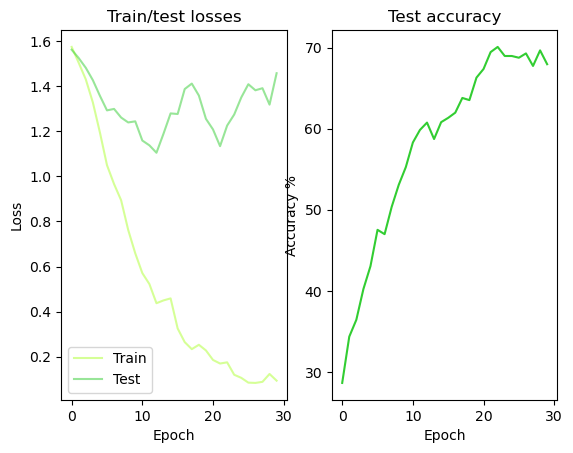

Wall time: 2min 8s


In [48]:
%%time
train_rnn(len(datas['balanced(tfidf)'][0]), datas['balanced(tfidf)'][1], datas['balanced(tfidf)'][2],
          30, 100, 128, 1)

Epoch - TestAcc:
0-27.84%|1-32.16%|2-35.20%|3-39.31%|4-41.87%|5-45.81%|6-44.32%|7-47.57%|8-48.37%|9-50.35%|10-52.27%|11-54.29%|12-55.57%|13-56.37%|14-59.04%|15-59.36%|16-62.61%|17-61.92%|18-62.67%|19-62.67%|20-64.53%|21-64.80%|22-64.43%|23-63.36%|24-64.64%|25-61.97%|26-66.45%|27-64.37%|28-66.24%|29-67.15%|

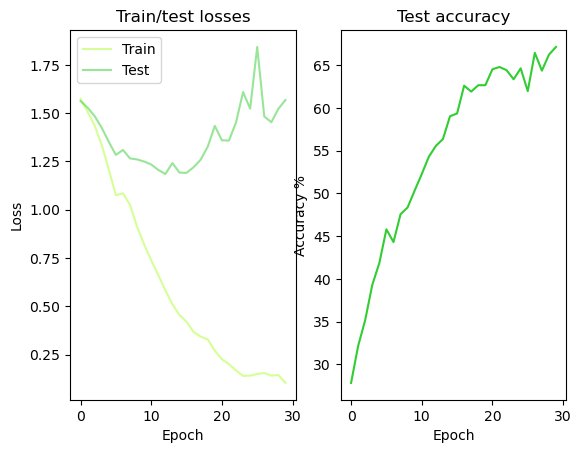

Wall time: 2min 11s


In [49]:
%%time
train_rnn(len(datas['balanced(countv)'][0]), datas['balanced(countv)'][1], datas['balanced(countv)'][2],
          30, 100, 128, 1)

На балансированных моделях точность достигает 70%, но наблюдается сильное переобучение, так как функция ошибки на тестовом датесете растёт параллельно с падением функции ошибки на тренировочном датасете.

Epoch - TestAcc:
0-69.49%|1-70.74%|2-78.67%|3-77.55%|4-80.62%|5-74.54%|6-71.69%|7-74.28%|8-72.12%|9-81.66%|10-77.52%|11-76.78%|12-79.05%|13-80.26%|14-83.87%|

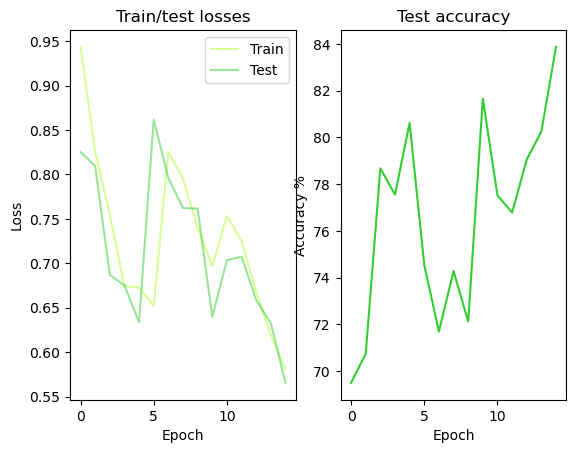

Wall time: 3min 36s


In [100]:
%%time
model = train_rnn(len(datas['unbalanced(tfidf)'][0]), datas['unbalanced(tfidf)'][1], datas['unbalanced(tfidf)'][2],
          15, 50, 128, 1)

Epoch - TestAcc:
0-69.60%|1-70.98%|2-77.50%|3-79.73%|4-83.78%|5-83.85%|6-84.53%|7-85.01%|8-84.16%|9-85.83%|10-86.48%|11-86.15%|12-85.54%|13-85.44%|14-85.88%|

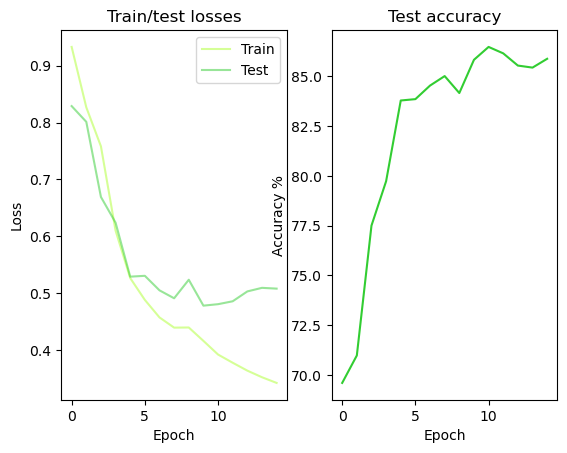

In [42]:
model = train_rnn(len(datas['unbalanced(countv)'][0]), datas['unbalanced(countv)'][1], datas['unbalanced(countv)'][2],
          15, 50, 128, 1)

На дисбалансном датасете исчезло переобучение и выросла точность. Однако она немного не догоняет точности наиболее эффективной классической модели - SVC: 86% против 89%.

Предсказание оценки на обученной модели:

In [94]:
def predict_review(review, model, vocab):
    stop_words = set(stopwords.words('russian')) # незначащие русские слова
    lemma = MorphAnalyzer() # лематизатор русского текста
    model.eval()
    with torch.no_grad():
        review = [token.text for token in tokenize(review)]
        review = [vocab[word] for word in review]
        tensor = torch.LongTensor(review).unsqueeze(0)
        output = model(tensor)
        probability = torch.nn.functional.softmax(output, dim=1)[0]
        pred = torch.argmax(probability).item() + 1
        return pred

In [95]:
predict_review("Отличное обслуживание, лучше всех!", model, datas['unbalanced(countv)'][0])

5

In [97]:
predict_review("Просто ужасно", model, datas['unbalanced(countv)'][0])

1

In [96]:
predict_review("добрый день, сегодня пытался перевести 260 руб. с карты 0964 на карту 3584 и почему-то система все время барахлила, писала что-то пошло не так и повторите попытку позже. Потратил на это казалось бы секундное дело целых полчаса!!!", model, datas['unbalanced(countv)'][0])

1

In [98]:
predict_review("В целом доволен обслуживанием, исправляют ошибки, которые встречались ранее", model, datas['unbalanced(countv)'][0])

5

В целом модель, обученная на дисбалансе классов с точностью в 86 % предсказывает введённые отзывы довольно точно, но по метрике точности на тестовых данных уступает классическим моделям.